# 新しいネットワークを書いてみよう

ここでは、MNISTデータセットではなくCIFAR10という32x32サイズの小さなカラー画像に10クラスのいずれかのラベルがついたデータセットを用いて、いろいろなモデルを自分で書いて試行錯誤する流れを体験してみます。

| airplane | automobile | bird | cat | deer | dog | frog | horse | ship | truck |
|:--------:|:----------:|:----:|:---:|:----:|:---:|:----:|:-----:|:----:|:-----:|
| ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck4.png) |

## 1. モデルの定義

モデルは、`Chain`クラスを継承して定義します。ここでは、以前試した全結合層だけからなるネットワークではなく、畳込み層を持つネットワークを定義してみます。このモデルは3つの畳み込み層を持ち、2つの全結合層がそのあとに続いています。

モデルの定義は主に2つのメソッドの定義によって行います。

1. コンストラクタでモデルを構成するレイヤーを定義する
    - この際、親クラス（`Chain`）のコンストラクタにキーワード引数として構成する`Link`オブジェクトを渡すことで`Optimizer`から捕捉可能な最適化対象のパラメータを持つレイヤをモデルに追加することができます。
2. `()`アクセサでデータを受け取り、Forward計算を行う`__call__`メソッドを定義する

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L

class MyModel(chainer.Chain):
    
    def __init__(self, n_out):
        super(MyModel, self).__init__(
            conv1=L.Convolution2D(None, 32, 3, 3, 1),
            conv2=L.Convolution2D(32, 64, 3, 3, 1),
            conv3=L.Convolution2D(64, 128, 3, 3, 1),
            fc4=L.Linear(None, 1000),
            fc5=L.Linear(1000, n_out)
        )
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

## 2. 学習

ここで、あとから別のモデルも簡単に同じ設定で訓練できるよう、`train`関数を定義しておきます。これは、モデルのオブジェクトを渡すと、中で`Trainer`を用いてCIFAR10データセットの画像を10クラスに分類するようにそのモデルを訓練し、学習が終了したモデルを返す関数です。

この`train`関数を用いて、上で定義した`MyModel`モデルを訓練してみます。

In [2]:
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

def train(model_object, batchsize=64, gpu_id=0, max_epoch=20):

    # 1. Dataset
    train, test = cifar.get_cifar10()

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id > 0:
        model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10_result'.format(model_object.__class__.__name__))

    # 7. Evaluator

    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            model.train = False
            ret = super(TestModeEvaluator, self).evaluate()
            model.train = True
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer
    
    return model
    
model = train(MyModel(10), gpu_id=-1)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           333523      0.120225       2.55064e+06           0.10619                   53.559        
2           1.06412e+07  0.117398       3.95169e+07           0.107783                  122.088       
3           5.26214e+07  0.118878       8.9406e+07            0.144805                  174.212       
4           1.65046e+08  0.119358       2.55771e+08           0.0998209                 240.534       
5           3.34906e+08  0.117267       2.069e+08             0.120024                  307.484       
6           6.23068e+08  0.120639       8.80352e+08           0.140525                  369.61        
7           9.71077e+08  0.122159       1.43472e+09           0.144904                  421.594       
8           1.53544e+09  0.121759       1.87129e+09           0.141023                  484.592       
9           2.07508e+09  0.118486       1.88686e+09           0.16252        

学習が一通り終わりました。ロスと精度のプロットを見てみましょう。

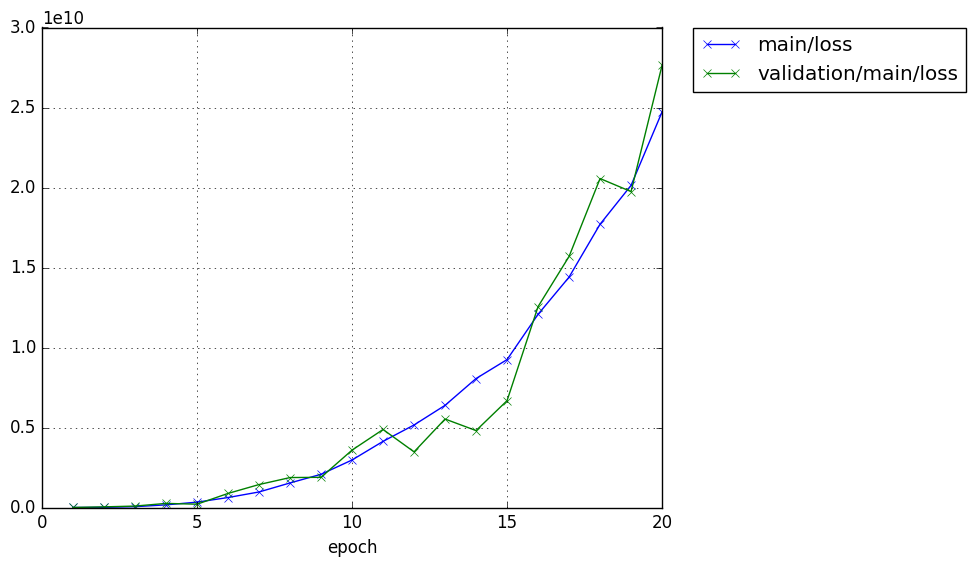

In [3]:
from IPython.display import Image
Image(filename='MyModel_cifar10_result/loss.png')

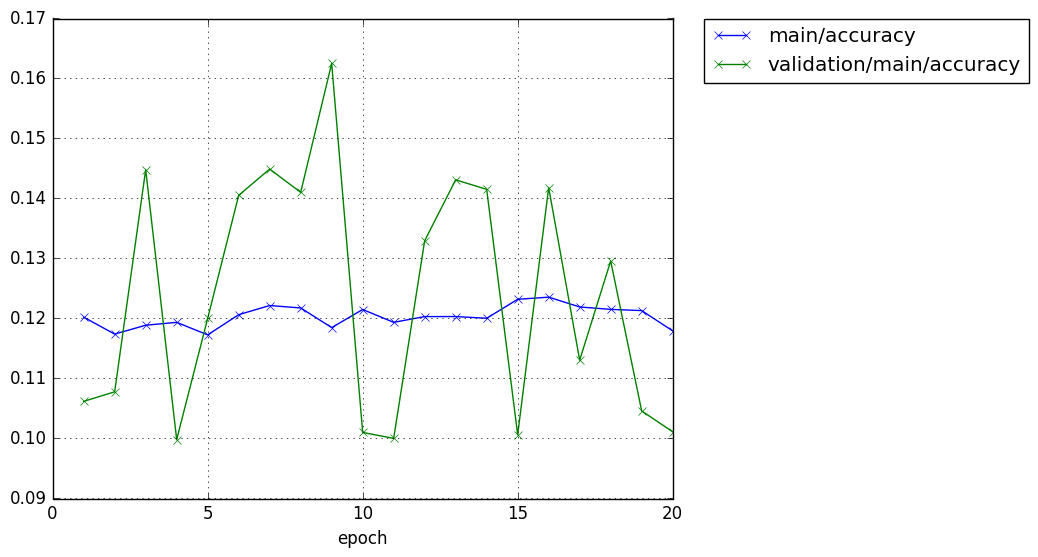

In [4]:
Image(filename='MyModel_cifar10_result/accuracy.png')

学習データでの精度は97%付近まで到達していますが、テストデータではロスはむしろIterationを進むごとに大きくなってしまっており、また精度も60%付近で頭打ちになってしまっています。**モデルが学習データにオーバーフィッティングしている**と思われます。

## 3. 学習済みモデルを使った予測

テスト精度は60%程度でしたが、この学習済みモデルを使っていくつかのテスト画像を分類させてみましょう。

predicted_label: deer
answer: cat


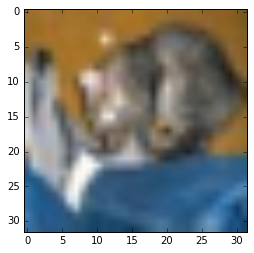

predicted_label: deer
answer: ship


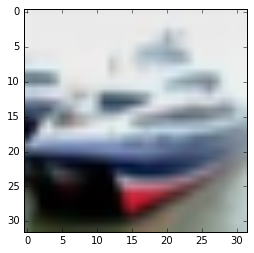

predicted_label: deer
answer: ship


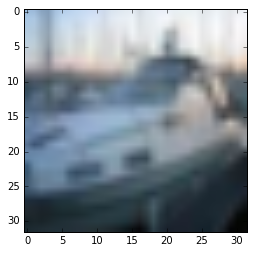

predicted_label: deer
answer: airplane


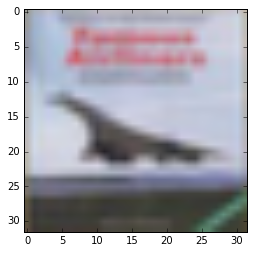

predicted_label: deer
answer: frog


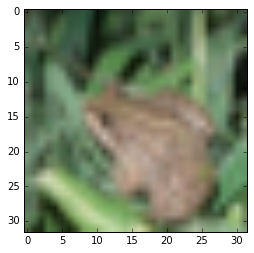

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(model, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    model.to_cpu()
    y = model.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

for i in range(5):
    predict(model, i)

うまく分類できているものもあれば、そうでないものもありました。モデルの学習に使用したデータセット上ではほぼ百発百中で正解できるとしても、未知のデータ、すなわちテストデータセットにある画像に対して高精度な予測ができなければ、意味がありません。テストデータでの精度は、モデルの**汎化性能**に関係していると言われます。

どうすれば高い汎化性能を持つモデルを設計し、学習することができるでしょうか？

## 4. もっと深いモデルを定義してみよう

では、上のモデルよりもよりたくさんの層を持つモデルを定義してみましょう。ここでは、1層の畳み込みネットワークを`ConvBlock`、1層の全結合ネットワークを`LinearBlock`として定義し、これをたくさんシーケンシャルに積み重ねる方法で大きなネットワークを定義してみます。

### 構成要素を定義する

まず、今目指している大きなネットワークの構成要素となる`ConvBlock`と`LinearBlock`を定義してみましょう。

In [6]:
class ConvBlock(chainer.Chain):
    
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__(
            conv=L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w),
            bn=L.BatchNormalization(n_ch)
        )
        
        self.train = True
        self.pool_drop = pool_drop
        
    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25, train=self.train)
        return h
    
class LinearBlock(chainer.Chain):
    
    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__(
            fc=L.Linear(None, 1024, initialW=w))
        self.train = True
        
    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5, train=self.train)

`ConvBlock`は`Chain`を継承したモデルとして定義されています。これは一つの畳み込み層とBatch Normalization層をパラメータありで持っているので、これらをコンストラクタで登録しています。`__call__`メソッドでは、これらにデータを渡しつつ、活性化関数を適用して、さらに`pool_drop`がコンストラクタに`True`で渡されているときはMax PoolingとDropoutという関数を適用するような小さなネットワークになっています。

Chainerでは、Pythonを使って書いたforward計算のコード自体がモデルを表します。すなわち、実行時にデータがどのような層をくぐっていったか、ということがネットワークそのものを定義します。これによって、このような分岐を含むようなネットワークも簡単に書け、柔軟かつシンプルで可読性の高いネットワーク定義が可能になります。これが**Define-by-Run**と呼ばれる特徴です。

### 大きなネットワークの定義

次に、これらの小さなネットワークを構成要素として積み重ねて、大きなネットワークを定義してみましょう。

In [7]:
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        self._train = True
            
    @property
    def train(self):
        return self._train
            
    @train.setter
    def train(self, val):
        self._train = val
        for c in self.children():
            c.train = val
    
    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x

ここで利用しているのが、`ChainList`というクラスです。このクラスは`Chain`を継承したクラスで、いくつもの`Link`や`Chain`を順次呼び出していくようなネットワークを定義するときに便利です。`ChainList`を継承して定義されるモデルは、親クラスのコンストラクタを呼び出す際に**キーワード引数ではなく普通の引数として**`Link`もしくは`Chain`オブジェクトを渡すことができます。そしてこれらは、**self.children()**メソッドによって**登録した順番に**取り出すことができます。

この特徴を使うと、forward計算の記述が簡単になります。**self.children()**が返す構成要素のリストから、for文で構成要素を順番に取り出していき、そもそもの入力である`x`に取り出してきた部分ネットワークの計算を適用して、この出力で`x`を置き換えるということを順番に行っていけば、一連の`Link`または`Chain`を、コンストラクタで親クラスに登録した順番と同じ順番で適用していくことができます。そのため、シーケンシャルな部分ネットワークの適用によって表される大きなネットワークを定義するのに重宝します。

In [8]:
model = train(DeepCNN(10), max_epoch=100)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.97829     0.27092        1.65301               0.381668                  19.6033       
2           1.45983     0.462348       1.28414               0.542297                  39.5244       
3           1.15899     0.588508       1.03313               0.640824                  59.5399       
4           0.930922    0.677417       0.887119              0.701533                  79.9152       
5           0.782591    0.735574       0.781166              0.750199                  100.145       
6           0.670051    0.779269       0.67006               0.783041                  120.556       
7           0.58812     0.805898       0.669039              0.78324                   140.891       
8           0.52252     0.824984       0.645533              0.794685                  161.289       
9           0.473104    0.845488       0.590496              0.812301               

学習が終了しました。ロスと精度のグラフを見てみましょう。

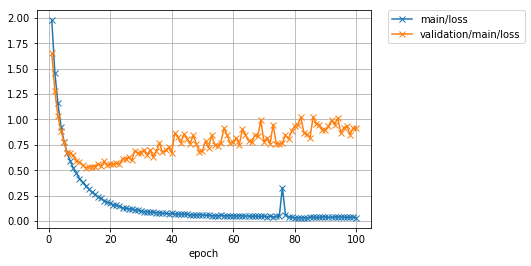

In [9]:
Image(filename='DeepCNN_cifar10_result/loss.png')

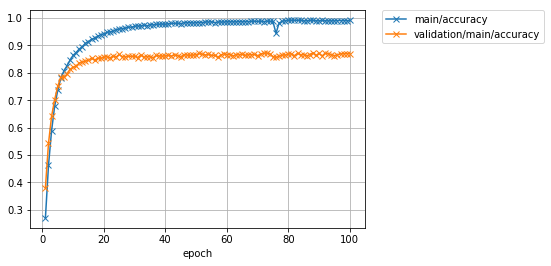

In [10]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

先程よりも大幅にテストデータに対する精度が向上したことが分かります。60%前後だった精度が、87%程度まで上がりました。しかし最新の研究成果では97%近くまで達成されています。さらに精度を上げるには、今回行ったようなモデルの改良ももちろんのこと、学習データを擬似的に増やす操作（Data augmentation）や、複数のモデルの出力を一つの出力に統合する操作（Ensemble）などなど、いろいろな工夫が考えられます。